In [1]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

2024-04-13 12:50:21.494508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 12:50:21.494623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 12:50:21.622708: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import pandas as pd

# Read data from the specific sheet named "modified_data"
df_org = pd.read_excel("/kaggle/input/final-check/Gitadataset.xlsx", sheet_name="Sheet1")
# df_org = pd.read_csv("/kaggle/input/testrun01/DatasetForGita.csv")

# Shuffle the data
df_org = df_org.sample(frac=1.0, random_state=42)

# Display the first few rows of the DataFrame
print(df_org.head())

                                                    Text  \
3284     হোপ   ফেরারি গোলাপী ঝলমলে পড়া পাস্তা পড়ার ...   
7900   চলতি বছর পহেলা জানুয়ারি থেকে ডেঙ্গু জ্বরে আক্র...   
16492  আমি সত্যিকারের যত্ন নিতে চাই না কারণ আমি যা কর...   
6906   সরকারের নির্দেশনানুযায়ী মাদকের বিরুদ্ধে যেমন ‘...   
17489  সোজা বাংলায় ডাকাতি দেখাইলে এটা এতো জনপ্রিয় হইত...   

                                              text_clean     Emotion  
3284      হোপ ফেরারি গোলাপী ঝলমলে পড়া পাস্তা পড় পেইন্ট    Surprise  
7900   চলতি বছর পহেলা জানুয়ারি ডেঙ্গু জ্বরে আক্রান্ত ...     Sadness  
16492                         সত্যিকার যত্ন চাই পচা লাগে     Sadness  
6906   সরকার নির্দেশনানুযায়ী মাদক বিরুদ্ধে জিরো প্রদর...  Optimistic  
17489  সোজা বাংলায় ডাকাতি দেখাইলে এত জনপ্রিয় হইতো সবক...     Annoyed  


In [4]:
# import pandas as pd

# # Read data from the "modified_data" sheet
# df_modified = pd.read_excel("/kaggle/input/testdataset2/DatasetForGita.xlsx", sheet_name="modified_data")

# # Read data from the "25K" sheet
# df_25k = pd.read_excel("/kaggle/input/testdataset2/DatasetForGita.xlsx", sheet_name="25K")

# # Shuffle the data in both dataframes
# df_modified = df_modified.sample(frac=1.0, random_state=42)
# df_25k = df_25k.sample(frac=1.0, random_state=42)

# # Merge both dataframes
# df_org = pd.concat([df_modified, df_25k], ignore_index=True)

# # Display the first few rows of the merged DataFrame
# print(df_org.head())

In [5]:
# Drop duplicates
df_org.drop_duplicates(subset=['text_clean'], inplace=True)

# Drop rows with empty text_clean
df_org.dropna(subset=['text_clean'], inplace=True)

In [6]:
data_count = df_org.shape[0]
print("Remaining data count after deleting duplicates and empty rows:", data_count)


Remaining data count after deleting duplicates and empty rows: 27219


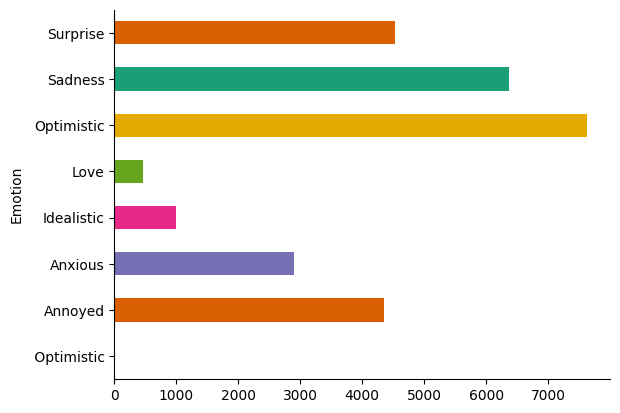

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
df_org.groupby('Emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
# !pip install bangla-stemmer

In [9]:
# from bangla_stemmer.stemmer import stemmer

# stmr = stemmer.BanglaStemmer()

# valid_bangla_char = set(['া','ি','ী','ু','ূ','ৃ','ে','ৈ','ো','ৌ','ক','খ',
# 'গ','ঘ','ঙ','চ','ছ','জ','ঝ','ঞ','ট','ঠ','ড','ঢ','ণ','ত','থ','দ','ধ','ন',
# 'প','ফ','ব','ভ','ম','য','র','ল','শ','ষ','স','হ','ড়','ঢ়','য়','ৎ','ং','ঃ'
# '‍ঁ','‍্','‍্য','‍‍্র','‍‍র্ক','‍্ব','৺','ক্ষ','জ্ঞ','অ','আ','ই','ঈ','উ','ঊ','ঋ','এ',
# 'ঐ','ও','ঔ','অ্যা','্','য়','ঁ','ড়','়','ঃ'])

# stop_words = set([''])
# stop_words_file_lines=open('/kaggle/input/stopwordscheck/stop_words.txt','r',encoding='utf-8-sig').readlines()
# for word in stop_words_file_lines:
#     stop_words.add(word.strip())

# def puncuation_removal(sentence):
#     words = sentence.split()
#     unique_words_per_sentence = []
#     for every_word in words:
#         correct_word = ''
#         for each_char in every_word:
#             if each_char in valid_bangla_char:
#                 correct_word += each_char
#             else:
#                 correct_word = ''
#         if correct_word not in stop_words:
#             unique_words_per_sentence.append(correct_word.strip())
#         correct_word = ''

#     new_refined_sentence = ' '.join(stmr.stem(unique_words_per_sentence))

#     return new_refined_sentence

# df_org["text_clean"] = df_org["Text"].apply(lambda x: puncuation_removal(x))
# df_org.head()

In [10]:
labels = df_org['Emotion'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Surprise',
 'Sadness',
 'Optimistic',
 'Annoyed',
 'Idealistic',
 'Anxious',
 'Love',
 'Optimistic']

In [11]:
for key, value in enumerate(labels):
    print(value)

Surprise
Sadness
Optimistic
Annoyed
Idealistic
Anxious
Love
Optimistic


In [12]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [13]:
label2id

{'Surprise': 0,
 'Sadness': 1,
 'Optimistic': 7,
 'Annoyed': 3,
 'Idealistic': 4,
 'Anxious': 5,
 'Love': 6}

In [14]:
id2label

{0: 'Surprise',
 1: 'Sadness',
 2: 'Optimistic',
 3: 'Annoyed',
 4: 'Idealistic',
 5: 'Anxious',
 6: 'Love',
 7: 'Optimistic'}

In [15]:
df_org.head()

,Text,text_clean,Emotion
3284,হোপ ফেরারি গোলাপী ঝলমলে পড়া পাস্তা পড়ার ...,হোপ ফেরারি গোলাপী ঝলমলে পড়া পাস্তা পড় পেইন্ট,Surprise
7900,চলতি বছর পহেলা জানুয়ারি থেকে ডেঙ্গু জ্বরে আক্র...,চলতি বছর পহেলা জানুয়ারি ডেঙ্গু জ্বরে আক্রান্ত ...,Sadness
16492,আমি সত্যিকারের যত্ন নিতে চাই না কারণ আমি যা কর...,সত্যিকার যত্ন চাই পচা লাগে,Sadness
6906,সরকারের নির্দেশনানুযায়ী মাদকের বিরুদ্ধে যেমন ‘...,সরকার নির্দেশনানুযায়ী মাদক বিরুদ্ধে জিরো প্রদর...,Optimistic
17489,সোজা বাংলায় ডাকাতি দেখাইলে এটা এতো জনপ্রিয় হইত...,সোজা বাংলায় ডাকাতি দেখাইলে এত জনপ্রিয় হইতো সবক...,Annoyed


In [16]:
df_org["labels"]=df_org.Emotion.map(lambda x: label2id[x.strip()])

In [17]:
df_org.head(30)

,Text,text_clean,Emotion,labels
3284,হোপ ফেরারি গোলাপী ঝলমলে পড়া পাস্তা পড়ার ...,হোপ ফেরারি গোলাপী ঝলমলে পড়া পাস্তা পড় পেইন্ট,Surprise,0
7900,চলতি বছর পহেলা জানুয়ারি থেকে ডেঙ্গু জ্বরে আক্র...,চলতি বছর পহেলা জানুয়ারি ডেঙ্গু জ্বরে আক্রান্ত ...,Sadness,1
16492,আমি সত্যিকারের যত্ন নিতে চাই না কারণ আমি যা কর...,সত্যিকার যত্ন চাই পচা লাগে,Sadness,1
6906,সরকারের নির্দেশনানুযায়ী মাদকের বিরুদ্ধে যেমন ‘...,সরকার নির্দেশনানুযায়ী মাদক বিরুদ্ধে জিরো প্রদর...,Optimistic,7
17489,সোজা বাংলায় ডাকাতি দেখাইলে এটা এতো জনপ্রিয় হইত...,সোজা বাংলায় ডাকাতি দেখাইলে এত জনপ্রিয় হইতো সবক...,Annoyed,3
14931,আমি হতাশ হয়ে পড়ি এটি বিশেষ করে প্রিয়জনের দ্...,হতাশ পড়ি প্রিয়জন হতাশ এত প্রত্যাখ্যাত,Sadness,1
20123,"বাড়ি এসে দেখেন তাঁর পুরো বাড়ি পুলিশ, মেডিক্যাল...",বাড়ি দেখেন পুরো বাড়ি মেডিক্যাল ডাক্ত সরকারী লো...,Annoyed,3
24021,আমি আজ রাতের খাবারের জন্য এটি তৈরি করাকে আমি খ...,রাত খাবারের তৈরি করা পুণ্যময় বোধ কর,Optimistic,7
5138,আমি বিশ্বাস করি যে ভয়ের মতো অনুভূতিটি এই মুহূ...,বিশ্বাস ভয় অনুভূতি মুহূর্ কিছুক্ষন উপেক্ষা দমন,Sadness,1
21910,আমার মনে হয় এরা স্বর্গে গেলেও পায়খানা করতে চাই...,স্বর্গে গাল পায়খানা যদিওবা ব্যবস্থা ঘৃনা লিখসে...,Annoyed,3


<Axes: ylabel='count'>

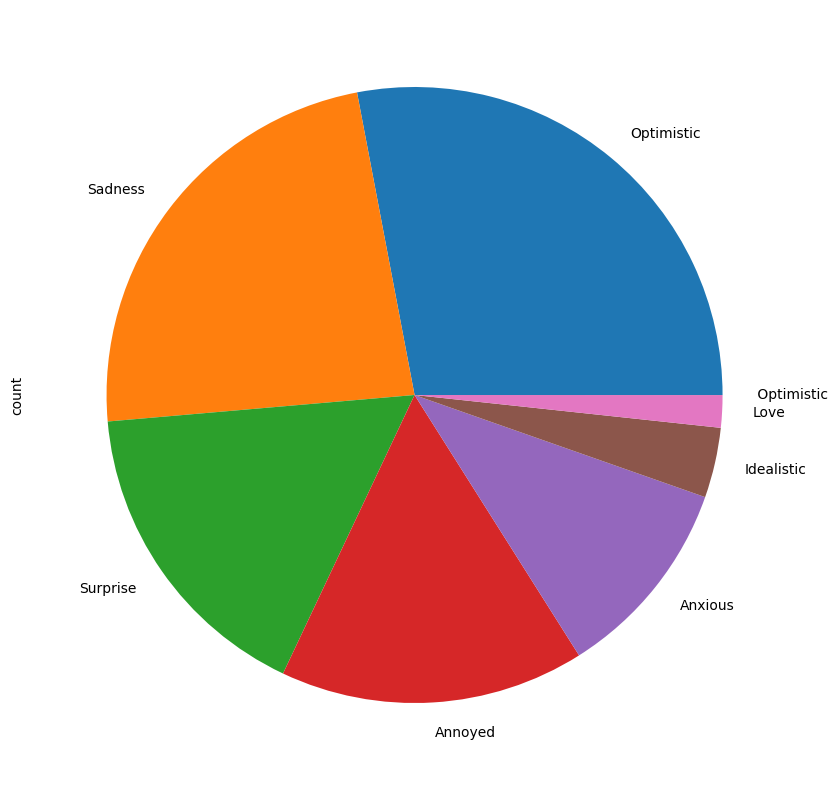

In [18]:
df_org.Emotion	.value_counts().plot(kind='pie', figsize=(10,10))

In [19]:
tokenizer = BertTokenizerFast.from_pretrained("sagorsarker/bangla-bert-base", max_length=512)

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [20]:
# tokenizer = BertTokenizerFast.from_pretrained("csebuetnlp/banglabert", max_length=512)

In [21]:
# model = BertForSequenceClassification.from_pretrained("csebuetnlp/banglabert", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
# model.to(device)

In [22]:
model = BertForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

Improvement Here

SIZE = df_org.shape[0]

train_texts = list(df_org.text_clean[:int(0.75 * SIZE)])

val_texts = list(df_org.text_clean[int(0.75 * SIZE):int(0.875 * SIZE)])

test_texts = list(df_org.text_clean[int(0.875 * SIZE):])

train_labels = list(df_org.labels[:int(0.75 * SIZE)])

val_labels = list(df_org.labels[int(0.75 * SIZE):int(0.875 * SIZE)])

test_labels = list(df_org.labels[int(0.875 * SIZE):])

In [23]:
# SIZE= df_org.shape[0]

# train_texts= list(df_org.text_clean[:SIZE//2])

# val_texts=   list(df_org.text_clean[SIZE//2:(3*SIZE)//4 ])

# test_texts=  list(df_org.text_clean[(3*SIZE)//4:])

# train_labels= list(df_org.labels[:SIZE//2])

# val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

# test_labels=  list(df_org.labels[(3*SIZE)//4:])

SIZE = df_org.shape[0]

train_texts = list(df_org.Text[:int(0.75 * SIZE)])

val_texts = list(df_org.Text[int(0.75 * SIZE):int(0.875 * SIZE)])

test_texts = list(df_org.Text[int(0.875 * SIZE):])

train_labels = list(df_org.labels[:int(0.75 * SIZE)])

val_labels = list(df_org.labels[int(0.75 * SIZE):int(0.875 * SIZE)])

test_labels = list(df_org.labels[int(0.875 * SIZE):])

In [24]:
len(train_texts)

20414

In [25]:
len(train_texts), len(val_texts), len(test_texts)

(20414, 3402, 3403)

In [26]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [27]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [28]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [29]:
from transformers import TrainingArguments, Trainer

In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [31]:
# training_args = TrainingArguments(
#     # The output directory where the model predictions and checkpoints will be written
#     output_dir='/kaggle/working/TTC4900Model', 
#     do_train=True,
#     do_eval=True,
#     #  The number of epochs, defaults to 3.0 
#     num_train_epochs=6,              
#     per_device_train_batch_size=16,  
#     per_device_eval_batch_size=32,
#     # Number of steps used for a linear warmup
#     warmup_steps=100,                
#     weight_decay=0.01,
#     logging_strategy='steps',
#    # TensorBoard log directory                 
#     logging_dir='./kaggle/working/multi-class-logs',            
#     logging_steps=50,
#     evaluation_strategy="steps",
#     eval_steps=50,
#     save_strategy="steps", 
#     fp16=True,
#     load_best_model_at_end=True
# )

training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='/kaggle/working/TTC4900Model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=4,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./kaggle/working/multi-class-logs',            
    logging_steps=250,
    evaluation_strategy="steps",
    eval_steps=250,
    save_strategy="steps", 
    fp16=True,
    load_best_model_at_end=True
)

In [32]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [33]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
250,1.499300,1.151614,0.572016,0.457918,0.514797,0.473659
500,1.133000,1.045385,0.635509,0.570398,0.592821,0.563223
750,1.021100,0.972827,0.656966,0.555990,0.660805,0.556420
1000,0.964800,0.914999,0.662551,0.563511,0.694242,0.540955
1250,0.889500,0.887045,0.693416,0.581101,0.713264,0.603377
1500,0.659400,0.877622,0.707525,0.649512,0.685979,0.656768
1750,0.656600,0.858825,0.708701,0.672937,0.673107,0.690297
2000,0.667400,0.843437,0.703116,0.659453,0.701169,0.647477
2250,0.670000,0.808772,0.723986,0.701316,0.687142,0.728891
2500,0.625700,0.775029,0.733980,0.705188,0.698016,0.721911


TrainOutput(global_step=5104, training_loss=0.5846813444433541, metrics={'train_runtime': 3414.0385, 'train_samples_per_second': 23.918, 'train_steps_per_second': 1.495, 'total_flos': 1.4100025895553024e+16, 'train_loss': 0.5846813444433541, 'epoch': 4.0})

In [34]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.382135,0.872000,0.842672,0.833901,0.860476
val,0.775029,0.733980,0.705188,0.698016,0.721911
test,0.764644,0.729063,0.668679,0.668141,0.680962


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming the trainer provides predictions and true labels
train_predictions = trainer.predict(train_dataloader)
val_predictions = trainer.predict(val_dataloader)
test_predictions = trainer.predict(test_dataset)  # Assuming test_dataloader exists

# Extracting predicted labels and true labels
train_pred_labels = train_predictions.predictions.argmax(axis=1)
val_pred_labels = val_predictions.predictions.argmax(axis=1)
test_pred_labels = test_predictions.predictions.argmax(axis=1)

# Assuming train_encodings, val_encodings, test_encodings contain the data
train_true_labels = train_labels
val_true_labels = val_labels
test_true_labels = test_labels

# Compute evaluation metrics
train_report = classification_report(train_true_labels, train_pred_labels)
val_report = classification_report(val_true_labels, val_pred_labels)
test_report = classification_report(test_true_labels, test_pred_labels)

train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
val_conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
test_conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Display evaluation metrics
print("Train Set Metrics:")
print(train_report)
print("Train Set Confusion Matrix:")
print(train_conf_matrix)

print("\nValidation Set Metrics:")
print(val_report)
print("Validation Set Confusion Matrix:")
print(val_conf_matrix)

print("\nTest Set Metrics:")
print(test_report)
print("Test Set Confusion Matrix:")
print(test_conf_matrix)


Train Set Metrics:
              precision    recall  f1-score   support

           0       0.96      0.86      0.90      3357
           1       0.87      0.86      0.86      4744
           3       0.90      0.81      0.85      3372
           4       0.70      0.95      0.81       746
           5       0.74      0.89      0.81      2156
           6       0.76      0.73      0.74       340
           7       0.91      0.91      0.91      5699

    accuracy                           0.87     20414
   macro avg       0.83      0.86      0.84     20414
weighted avg       0.88      0.87      0.87     20414

Train Set Confusion Matrix:
[[2882   46   29   13  218   11  158]
 [  36 4087  169   38  257    0  157]
 [  27  339 2736   27  135    0  108]
 [   1    4    3  712    0   20    6]
 [  26   77   53    4 1928   10   58]
 [   0    1    0   78    4  248    9]
 [  41  155   44  138   74   39 5208]]

Validation Set Metrics:
              precision    recall  f1-score   support

         

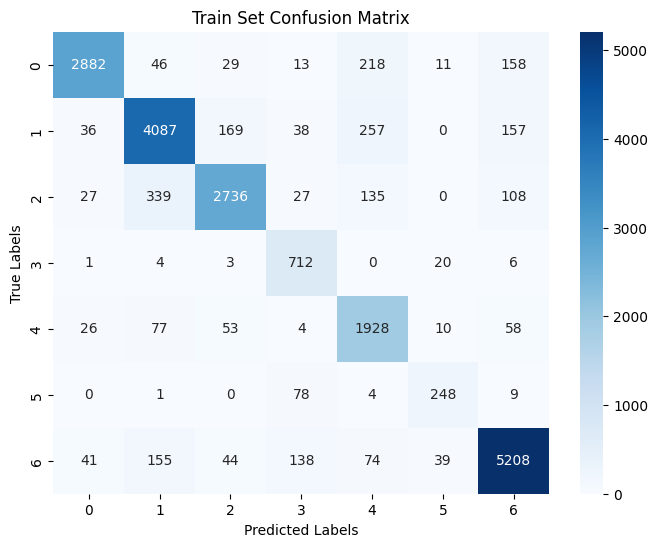

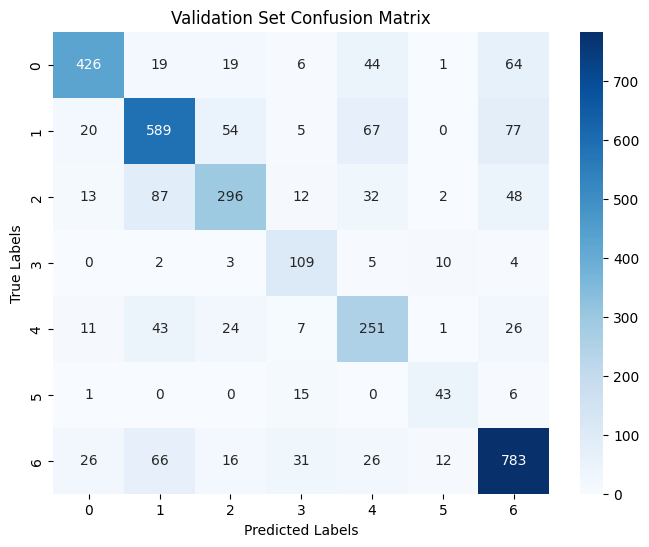

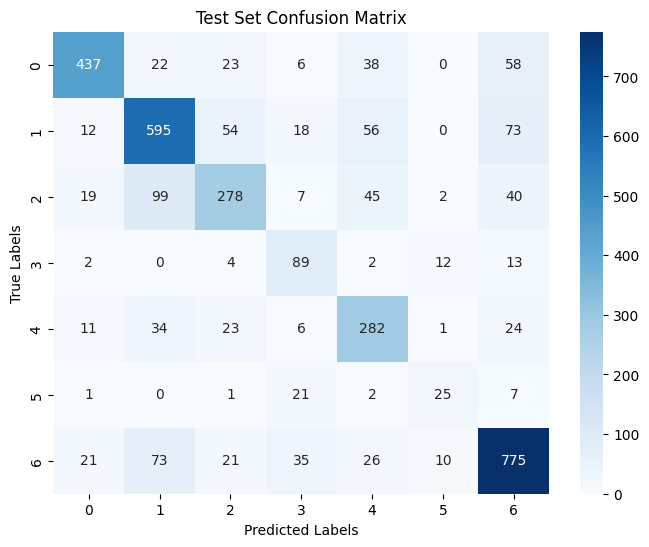

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have computed confusion matrices for train, validation, and test sets
# train_conf_matrix, val_conf_matrix, test_conf_matrix

# Define class labels if not already defined
class_labels = [0, 1, 2, 3, 4,5,6]  # Update this with your actual class labels

# Plot confusion matrix for train set
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train Set Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Validation Set Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [41]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [42]:
# Aggregate metrics from classification reports
def aggregate_metrics(report):
    lines = report.split('\n')
    metrics = {}
    for line in lines[2:-5]:  # skipping header and footer lines
        line = line.strip()
        if line:
            class_name, precision, recall, f1_score, _ = line.split()
            metrics[class_name] = {
                'precision': float(precision),
                'recall': float(recall),
                'f1-score': float(f1_score)
            }
    return metrics

# Compute average metrics over all classes
def compute_average_metrics(metrics):
    precision_sum = 0
    recall_sum = 0
    f1_score_sum = 0
    for class_name, scores in metrics.items():
        precision_sum += scores['precision']
        recall_sum += scores['recall']
        f1_score_sum += scores['f1-score']
    num_classes = len(metrics)
    avg_precision = precision_sum / num_classes
    avg_recall = recall_sum / num_classes
    avg_f1_score = f1_score_sum / num_classes
    return avg_precision, avg_recall, avg_f1_score

# Aggregate metrics for train, validation, and test sets
train_metrics = aggregate_metrics(train_report)
val_metrics = aggregate_metrics(val_report)
test_metrics = aggregate_metrics(test_report)

# Compute average metrics
train_avg_precision, train_avg_recall, train_avg_f1_score = compute_average_metrics(train_metrics)
val_avg_precision, val_avg_recall, val_avg_f1_score = compute_average_metrics(val_metrics)
test_avg_precision, test_avg_recall, test_avg_f1_score = compute_average_metrics(test_metrics)

# Print average metrics
print("Average Metrics for Train Set:")
print("Precision:", train_avg_precision)
print("Recall:", train_avg_recall)
print("F1 Score:", train_avg_f1_score)

print("\nAverage Metrics for Validation Set:")
print("Precision:", val_avg_precision)
print("Recall:", val_avg_recall)
print("F1 Score:", val_avg_f1_score)

print("\nAverage Metrics for Test Set:")
print("Precision:", test_avg_precision)
print("Recall:", test_avg_recall)
print("F1 Score:", test_avg_f1_score)


Average Metrics for Train Set:
Precision: 0.8342857142857143
Recall: 0.8585714285714285
F1 Score: 0.8400000000000001

Average Metrics for Validation Set:
Precision: 0.6985714285714285
Recall: 0.7228571428571428
F1 Score: 0.7071428571428572

Average Metrics for Test Set:
Precision: 0.6685714285714285
Recall: 0.6828571428571429
F1 Score: 0.6685714285714285


In [43]:
# Test with a an example text in Turkish
text = "আমার ব্যথাগুলো আমারই থাক অশ্রুতে দুটি চোখ যায় ভরে যাক।"
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[1.0666e-01, 5.2193e-01, 3.7284e-04, 4.3316e-02, 1.3880e-03, 1.3709e-01,
          7.7403e-04, 1.8848e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(1, device='cuda:0'),
 'Sadness')

In [44]:
model_path = "/kaggle/working/verse-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('/kaggle/working/verse-text-classification-model/tokenizer_config.json',
 '/kaggle/working/verse-text-classification-model/special_tokens_map.json',
 '/kaggle/working/verse-text-classification-model/vocab.txt',
 '/kaggle/working/verse-text-classification-model/added_tokens.json',
 '/kaggle/working/verse-text-classification-model/tokenizer.json')

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


In [45]:
model_path = "/kaggle/working/verse-text-classification-model"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [46]:
nlp("মেয়েদের সবচেয়ে সুন্দর দেখায় কেঁদে ফেলার আগ মূহুর্তে।")

[{'label': 'Optimistic', 'score': 0.6680268049240112}]

In [ ]:
import pandas as pd

# Load the Excel file into a DataFrame
df = pd.read_csv("/kaggle/input/donebaba/DatasetForGita - Label2.csv")

# Iterate over each row
for index, row in df.iterrows():
    # Get the text from the desired column (change 'text_column' to the name of the column containing text)
    text = row['Text']
    
    # Perform sentiment analysis
    result = nlp(text)
    
    # Extract sentiment label and score
    sentiment_label = result[0]['label']
    sentiment_score = result[0]['score']
    
    # Set sentiment label and score in new columns (change 'label_column' and 'score_column' to desired column names)
    df.at[index, 'label_column'] = sentiment_label
    df.at[index, 'score_column'] = sentiment_score

# Save the DataFrame with sentiment analysis results to a new Excel file
df.to_excel("output_with_sentiment_analysis.xlsx", index=False)


In [ ]:
!zip -r file.zip /kaggle/working/verse-text-classification-model

In [ ]:

!cd /kaggle/working

In [ ]:
!tar -czvf my_work.zip -C . .